In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.text as mpltxt
import matplotlib.cm as cm
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
import torch
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid


sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})

<Figure size 432x288 with 0 Axes>

In [2]:
# plt.rcParams['figure.dpi'] = 1200
save_plots = False

## Load Data

In [3]:
###
#  construct a single dictionary from those of all the runs
###
def get_bo_res(which_results: str, nb_run: int, norm_type):
    assert "results" in which_results
    # initialize dict to store results 
    bo_res = pickle.load(
             open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, 
                                                              which_results, 
                                                              which_results, 0), 'rb'))
    for key in bo_res.keys():
        bo_res[key] = []
        
    # iterate though the runs
    for n in range(nb_run):
        # get results dict for specified run
        bo_res_file = pickle.load(
                     open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, 
                                                                      which_results, 
                                                                      which_results, n), 'rb'))
        
        # append results to end of list
        for key in bo_res_file.keys():
            key_res = bo_res_file[key]
            bo_res[key].append(key_res)
            
    return bo_res

In [4]:
# change to: "normalized" => "min_max" and "standardized" => "zscore"
normalization = "normalized" 

In [5]:
###
#  features and molecular simulation data
###
file = h5py.File("targets_and_{}_features.jld2".format(normalization), "r")

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:])) # ... Needs to be tensor?
# simulation data
y = [np.transpose(file["henry_y"][:]), 
     np.transpose(file["gcmc_y"][:])]

# total number of COFs in data set
nb_COFs = X.shape[0]

###
#  bayesian optimization data
###
# COF IDs used for initialization
init_cof_ids_file = pickle.load(open('search_results/{}/initializing_cof_ids_{}.pkl'.format(normalization, 
                                                                           normalization), 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']

nb_COFs_initialization = len(init_cof_ids[0])
nb_runs = len(init_cof_ids)

# random search 
random_search_res = pickle.load(open('search_results/{}/random_search_results.pkl'.format(normalization), 'rb'))

# multi-fidelity search
mfbo_res = get_bo_res('mfbo_results', nb_runs, normalization)

# single-fideliy search
sfbo_res = get_bo_res('sfbo_results', nb_runs, normalization)

# number of iterations per run
nb_iters = len(mfbo_res['acquired_set'][0])

###
#  quick checks
###
# structure of data
assert len(sfbo_res['ids_acquired'][0]) == nb_iters
assert len(random_search_res['ids_acquired'][0]) == nb_iters
assert sfbo_res['nb_COFs_initialization'][0] == nb_COFs_initialization

# each run has the correct initializing COFs
assert all([all(sfbo_res['ids_acquired'][r][:nb_COFs_initialization] == init_cof_ids[r]) 
            for r in range(nb_runs)])

In [6]:
# the max number of iterations needed for any of the runs
max_SFBO_iters = max(sfbo_res['BO_iter_top_cof_acquired'])
max_MFBO_iters = max(mfbo_res['BO_iter_top_cof_acquired'])

# the highest accumulated cost up to the max number of iterations needed
max_SFBO_cost = np.max(sfbo_res['accumulated_cost'][:][:max_SFBO_iters+1])
max_MFBO_cost = np.max(mfbo_res['accumulated_cost'][:][:max_MFBO_iters+1])


print("The max number of iterations needed for any of the runs -")
print("\tSFBO: {}".format(max_SFBO_iters))
print("\tMFBO: {}".format(max_MFBO_iters))
print("The highest accumulated cost up to the max number of iterations needed -")
print("\tSFBO: {} [hr]".format(max_SFBO_cost))
print("\tMFBO: {} [hr]".format(max_MFBO_cost))

The max number of iterations needed for any of the runs -
	SFBO: 93
	MFBO: 137
The highest accumulated cost up to the max number of iterations needed -
	SFBO: 837.0824344986678 [hr]
	MFBO: 307.78275458210027 [hr]


# Plots

### Helper functions

In [7]:
def get_distribution(res, maxes=False):
    # initialize arrays for dist.
    mu      = np.zeros(nb_iters)
    sig_bot = np.zeros(nb_iters)
    sig_top = np.zeros(nb_iters)
    
    ###
    #  look at all runs and get the dist.
    ###
    for i in range(1, nb_iters+1):
        if maxes:
            # max value acquired up to this point (over all runs)       
            vals_at_iter = np.array([max(res[r][:i]) for r in range(nb_runs)])
        else:
            # make an arrey of all the values at a given iteration
            vals_at_iter = np.array([res[r][i-1] for r in range(nb_runs)])
        assert np.size(vals_at_iter) == nb_runs
        mu[i-1]      = np.mean(vals_at_iter)
        sig_bot[i-1] = np.std(vals_at_iter[vals_at_iter < mu[i-1]])
        sig_top[i-1] = np.std(vals_at_iter[vals_at_iter > mu[i-1]])
        
    return  mu, sig_bot, sig_top

In [8]:
###
#  when, on average, is the top COF located? 
###
mfbo_mean_iter_top_cof = int(np.round(np.mean(mfbo_res['BO_iter_top_cof_acquired'])))
sfbo_mean_iter_top_cof = int(np.round(np.mean(sfbo_res['BO_iter_top_cof_acquired'])))

print("Average iterations to locate top COF - ")
print("MFBO:\t", mfbo_mean_iter_top_cof)
print("SFBO:\t", sfbo_mean_iter_top_cof)

Average iterations to locate top COF - 
MFBO:	 41
SFBO:	 50


SFBO  max search time =  473.4273023254342
MFBO  max search time =  167.71789185040532


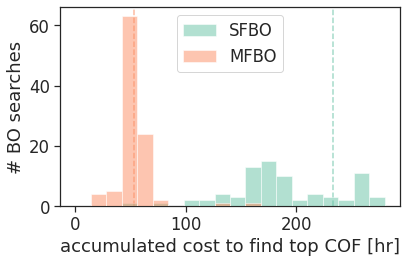

In [9]:
###
#  make a histogram of the distribution of accumulated cost 
###
fig = plt.figure()
width = 14
bins = np.array([int(width*i) for i in range(int(300 / width))])

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    x = []
    # color
    color = "C{}".format(i)
    
    for r in range(nb_runs):
        n = res['BO_iter_top_cof_acquired'][r]
        x.append(res['accumulated_cost'][r][n])
    
    print(search_type, " max search time = ", np.max(x))
    plt.axvline(x=np.mean(x), color=color, linestyle="--", lw=1.5, alpha=0.6)
    plt.hist(x, bins, label=search_type, color=color, alpha=0.5, zorder=10)


###
#  random search (high-fidelity, l=1)
###
# acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(random_search_res['accumulated_cost'])
# print("random dist'n max search time = ", np.max(acc_cost_mu))

# plt.axvline(x=np.mean(acc_cost_mu), color="C2", linestyle="--", lw=1.5, alpha=0.6)
# plt.hist(acc_cost_mu, bins, label="random", color="C2", alpha=0.5, zorder=2)

###
#  axis settings
###
plt.xlabel('accumulated cost to find top COF [hr]')
plt.ylabel('# BO searches')
plt.legend()


plt.tight_layout()
if save_plots:
    plt.savefig("./figs/hist_accumulated_cost_destribution.pdf", dpi=1200, format="pdf")
plt.show()

## Search Efficientcy Curves

In [10]:
### 
#  TODO: Turn this into a Function
###

def plot_search_data():
    return 

SFBO
2
93
MFBO
5
137


/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.p

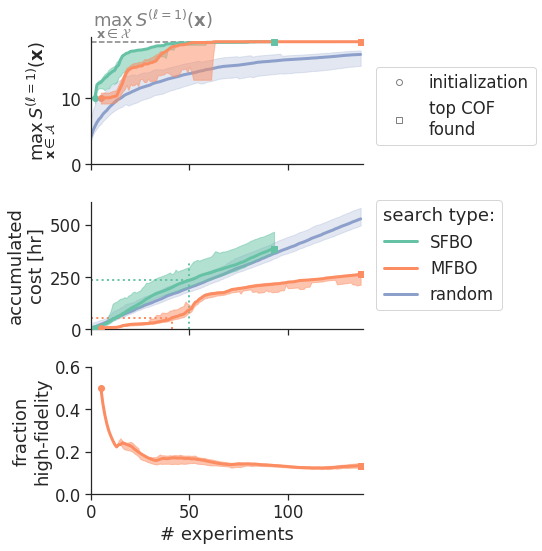

In [11]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))  
markers = dict({0 : '+', 1: 'x'})

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = "C{}".format(i)
    
    # important indexes
    print(search_type)
    iter_start = nb_COFs_initialization * (i + 1) - 1 # i + 1 is convenient hack :)
    print(iter_start)
    iter_top_cof_acquired = np.max(res['BO_iter_top_cof_acquired'])
    print(iter_top_cof_acquired)
    
    mean_iter_top_cof = int(np.round(np.mean(res['BO_iter_top_cof_acquired'])))

    
    iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
    ###
    #  get distributions 
    ###
    # y_maxes
    y_max_mu, y_max_sig_bot, y_max_sig_top = get_distribution(res['y_max_acquired'], maxes=True)
    # accumulated_cost
    acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(res['accumulated_cost'])
    
    ###
    #  accumulated cost
    ###
    ax[1].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               acc_cost_mu[iter_start:iter_top_cof_acquired+1], 
               label=search_type, 
               color=color, zorder=10)
    ax[1].fill_between(iter_range[iter_start:iter_top_cof_acquired+1],
                       acc_cost_mu[iter_start:iter_top_cof_acquired+1] - 
                                   acc_cost_sig_bot[iter_start:iter_top_cof_acquired+1],
                       acc_cost_mu[iter_start:iter_top_cof_acquired+1] + 
                                   acc_cost_sig_top[iter_start:iter_top_cof_acquired+1],
                       alpha=0.5, color=color, zorder=5)
    # average cost of search
    acc_ymax = acc_cost_mu[mean_iter_top_cof] / 450 # normed to max
    acc_xmax = mean_iter_top_cof / np.max(mfbo_res['BO_iter_top_cof_acquired'])
    
    ax[1].axvline(x=[mean_iter_top_cof], ymax=acc_ymax, 
                  color=color, lw=2, linestyle=":")
    ax[1].axhline(y=[acc_cost_mu[mean_iter_top_cof]], xmax=acc_xmax, 
                  color=color, lw=2, linestyle=":")
    # start and stop
    ax[1].scatter([iter_start], [acc_cost_mu[iter_start]], color=color, marker="o", zorder=100)
    ax[1].scatter([iter_top_cof_acquired], [acc_cost_mu[iter_top_cof_acquired]], 
                  color=color, marker="s", zorder=100)
    
    ###
    #  search efficiency curves
    ###    
    ax[0].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               y_max_mu[iter_start:iter_top_cof_acquired+1], 
               color=color, linestyle="-", zorder=10)
    ax[0].fill_between(iter_range[iter_start:iter_top_cof_acquired+1], 
                   y_max_mu[iter_start:iter_top_cof_acquired+1] - 
                                       y_max_sig_bot[iter_start:iter_top_cof_acquired+1], 
                   y_max_mu[iter_start:iter_top_cof_acquired+1] + 
                                       y_max_sig_top[iter_start:iter_top_cof_acquired+1],
                   alpha=0.5, color=color, zorder=5)
    # start and stop
    ax[0].scatter([iter_start], [y_max_mu[iter_start]], 
                  label='initialization',
                  color=color, marker="o")
    ax[0].scatter([iter_top_cof_acquired], y_max_mu[iter_top_cof_acquired+1], 
                  label='square', 
                  color=color, marker="s", zorder=100)
    
    ###
    #  fidelity fraction 
    ### 
    if search_type == "MFBO":
        # get dist.
        fid_frac_mu, fid_frac_sig_bot, fid_frac_sig_top = get_distribution(res['fidelity_fraction'])
        # plot
        ax[2].plot(iter_range[iter_start:iter_top_cof_acquired+1],
                   fid_frac_mu[iter_start:iter_top_cof_acquired+1], 
                   color=color)
        ax[2].fill_between(iter_range[iter_start:iter_top_cof_acquired+1],
                           fid_frac_mu[iter_start:iter_top_cof_acquired+1] - 
                                   fid_frac_sig_bot[iter_start:iter_top_cof_acquired+1],
                           fid_frac_mu[iter_start:iter_top_cof_acquired+1] + 
                                   fid_frac_sig_top[iter_start:iter_top_cof_acquired+1], 
                           alpha=0.5, color=color)
        # start and stop
        ax[2].scatter([iter_start], [fid_frac_mu[iter_start]], 
                      label='initialization',
                      color=color, marker="o")
        ax[2].scatter([iter_top_cof_acquired], fid_frac_mu[iter_top_cof_acquired+1], 
                      label='square', 
                      color=color, marker="s", zorder=100)

###
#  random search (SFBO, l=1)
###
iter_stop = np.max(mfbo_res['BO_iter_top_cof_acquired']) + 1
# y_maxes
ax[0].plot(range(iter_stop), random_search_res['y_rs_max_mu'][:iter_stop], 
           color="C2", zorder=2)

ax[0].fill_between(range(iter_stop), 
                   random_search_res['y_rs_max_mu'][:iter_stop] - 
                   random_search_res['y_rs_max_sig_bot'][:iter_stop], 
                   random_search_res['y_rs_max_mu'][:iter_stop] + 
                   random_search_res['y_rs_max_sig_top'][:iter_stop], 
                   alpha=0.25, color="C2", zorder=1)
# accumulated cost
acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(random_search_res['accumulated_cost'])
ax[1].plot(range(iter_stop), acc_cost_mu[:iter_stop], 
           label="random", color="C2", zorder=2)

ax[1].fill_between(range(iter_stop), 
                   acc_cost_mu[:iter_stop] - acc_cost_sig_bot[:iter_stop], 
                   acc_cost_mu[:iter_stop] + acc_cost_sig_top[:iter_stop], 
                   alpha=0.25, color="C2", zorder=1)

###  
#  global maximum
###
ax[0].axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
ax[0].text(1.0, max(y[1]) + 2.5, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, S^{(\ell=1)}(\mathbf{x})$", 
           color="gray")

###
#  axis settings
###
# search efficiency 
ax[0].set_xlim(xmin=0, xmax=iter_stop)
ax[0].set_ylim(ymin=0)
ax[0].set_ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, S^{(\ell=1)}(\mathbf{x})$')
# dummy plots for legend
p_empty_cir = ax[0].plot([], marker='o', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='initialization')
p_empty_sqr = ax[0].plot([], marker='s', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='top COF\nfound')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend([handles[0], handles[1]], [labels[0], labels[1]], loc=(1.05, 0.15))

# accumulated cost
ax[1].set_ylim(ymin=0)
ax[1].set_ylabel("accumulated\ncost [hr]")
ax[1].legend(title="search type:", loc=(1.05, 0.15))

# fidelity fraction
ax[2].set_ylim([0, 0.6])
ax[2].set_xlabel("# experiments")
ax[2].set_ylabel("fraction\nhigh-fidelity")

plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./figs/SearchEfficiency_AccCost_FidFrac_distributions.pdf", format="pdf")
plt.show()

In [12]:
def get_y_maxes_acquired(y_acquired):
    nb_iters = len(y_acquired)
    return [max(y_acquired[:i+1]) for i in range(nb_iters)]  

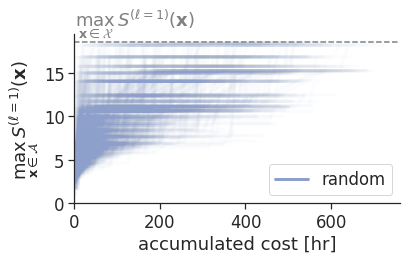

In [13]:
fig = plt.figure()

for i, rs_ids in enumerate(random_search_res['ids_acquired']):
    y_maxes = get_y_maxes_acquired(y[1][rs_ids.tolist()].tolist())
    iter_stop = np.argmax(y_maxes)

    if iter_stop == 0:
        iter_stop = 1

    plt.plot(random_search_res['accumulated_cost'][i].tolist()[:iter_stop], 
             y_maxes[:iter_stop], 
             color='C2', alpha=0.03)


plt.plot([], [], label='random', color='C2')

###  
#  global maximum
###
plt.axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
plt.text(1.0, max(y[1]) + 2.0, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, S^{(\ell=1)}(\mathbf{x})$", 
           color="gray")

###
#  axis settings
###
plt.xlim(xmin=0) # xmax=250
plt.ylim(ymin=0)
plt.xlabel("accumulated cost [hr]")
plt.ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, S^{(\ell=1)}(\mathbf{x})$')

plt.legend()

sns.despine()
plt.tight_layout()
if save_plots:
    plt.savefig("./figs/RandomSearch_AccCostDist.pdf", dpi=600, format='pdf')
plt.show()

mfbo_iter_top_cof_acquired =  40
16.71148068414794
[  1 375]
18.53448594783226


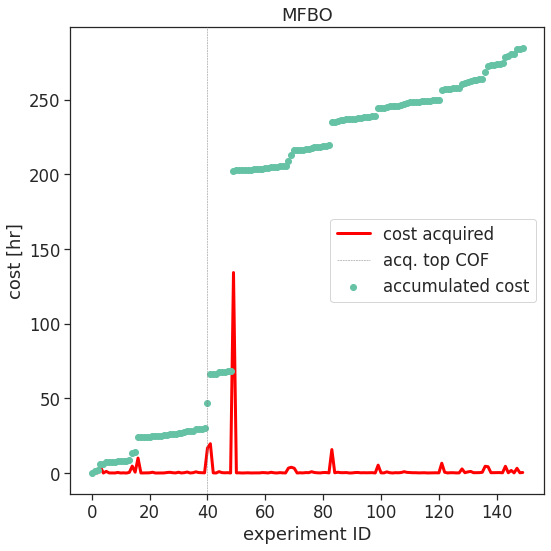

In [14]:
mfbo_iter_top_cof_acquired = mfbo_res['BO_iter_top_cof_acquired'][0] 

fig = plt.figure(figsize=(8,8))

plt.scatter(range(len(mfbo_res['accumulated_cost'][0])), 
            mfbo_res['accumulated_cost'][0], 
            color='C0', label='accumulated cost', zorder=5)

plt.plot(range(len(mfbo_res['cost_acquired'][0])), 
         mfbo_res['cost_acquired'][0]/60, label='cost acquired', color='red', zorder=2)

plt.axvline(x=mfbo_iter_top_cof_acquired, label='acq. top COF',
            color='gray', linestyle='--', lw=0.5, zorder=10)

plt.title('MFBO')
plt.xlabel('experiment ID')
plt.ylabel('cost [hr]')
plt.legend()

print('mfbo_iter_top_cof_acquired = ', mfbo_iter_top_cof_acquired)
print(mfbo_res['cost_acquired'][0][mfbo_iter_top_cof_acquired] / 60)
print(mfbo_res['acquired_set'][0][mfbo_iter_top_cof_acquired])
mid = mfbo_res['acquired_set'][0][mfbo_iter_top_cof_acquired][1]
print(y[1][mid])


plt.tight_layout()
plt.show()

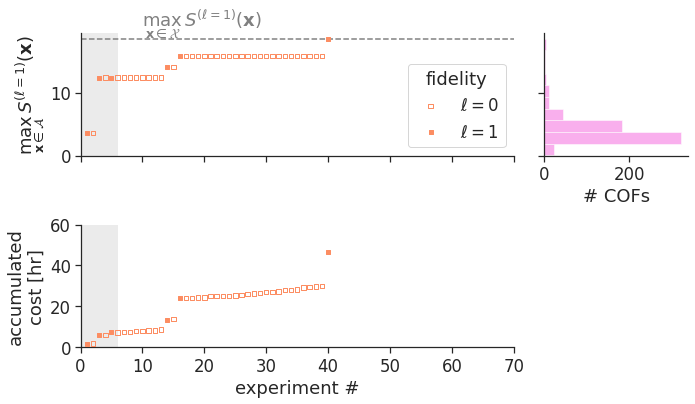

In [15]:
###
#  define constants useful for plotting
###
iter_start = 2 * nb_COFs_initialization
iter_top_cof_acquired = mfbo_res['BO_iter_top_cof_acquired'][0] 
iter_range = np.array(range(nb_iters)) 

_fids = mfbo_res['acquired_set'][0][:, 0]
mfbo_ymax_acq = mfbo_res['y_max_acquired'][0][:iter_top_cof_acquired+1]
mfbo_acc_cost = mfbo_res['accumulated_cost'][0][:iter_top_cof_acquired+1]

###
#  plot
###
gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [4, 4]} # set ratios
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(10, 6))

plt.subplots_adjust(hspace=0)

###
#  search efficiency vs accumulated cost
#  include scatter for search start and stop
###
ax[0,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == 0)[0][1:], 
                mfbo_ymax_acq[_fids[:iter_top_cof_acquired+1] == 0][1:],    
                label=r"$\ell = 0$",
                ec='C1', marker="s", fc="none", s=20, zorder=10) 

ax[0,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == 1)[0], 
                mfbo_ymax_acq[_fids[:iter_top_cof_acquired+1] == 1],   
                label=r"$\ell = 1$",
                color='C1', marker="s", s=20, zorder=10)

ax[0,0].axvspan(0, iter_start, color='C7', alpha=0.25, lw=0)

plt.setp(ax[0,0].get_xticklabels(), visible=False) # remove yticklabels


###  
#  global maximum
###
ax[0,0].axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
ax[0,0].text(10.0, max(y[1]) + 2.2, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, S^{(\ell=1)}(\mathbf{x})$", 
           color="gray")


###
#  histogram of selectivities
###
hist_cbar = sns.color_palette("husl", 8)
ax[0,1].hist(y[1], color=hist_cbar[7], alpha=0.5, orientation='horizontal')
ax[0,1].sharey(ax[0,0])
# ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('# COFs')
plt.setp(ax[0,1].get_yticklabels(), visible=False) # remove yticklabels


###
#  Accumulated cost
###
ax[1,0].sharex(ax[0,0])


ax[1,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == 0)[0][1:], 
                mfbo_acc_cost[_fids[:iter_top_cof_acquired+1] == 0][1:], 
                label='accumulated cost', 
                marker="s", ec='C1', fc='none', s=20, zorder=10) # fc="none",

ax[1,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == 1)[0], 
                mfbo_acc_cost[_fids[:iter_top_cof_acquired+1] == 1], 
                label='accumulated cost', 
                color='C1', marker="s", s=20, zorder=10)

ax[1,0].axvspan(0, iter_start, color='C7', alpha=0.25, lw=0)

ax[1,0].set_ylim(ymin=-0, ymax=60)
ax[1,0].set_xlabel('experiment #')
ax[1,0].set_ylabel("accumulated\ncost [hr]")
# plt.setp(ax[1,0].get_xticklabels(), visible=False) # remove yticklabels


###
#  remove extra axis
###
plt.delaxes(ax[1,1])

###
#  axis settings
###
# search efficiency 
ax[0,0].set_xlim(xmin=-0, xmax=70)
ax[0,0].set_ylim(ymin=0)
ax[0,0].set_ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, S^{(\ell=1)}(\mathbf{x})$')
ax[0,0].legend(title="fidelity", loc=4, ncol=1)


plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./figs/MFBO_multipanel.pdf", bbox_inches="tight", format="pdf")
plt.show()

SFBO
2
28
MFBO
5
40


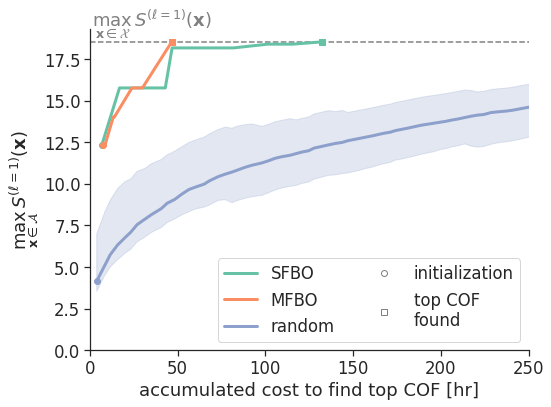

In [16]:
fig = plt.figure(figsize=(8, 6))  
markers = dict({0 : '+', 1: 'x'})

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = "C{}".format(i)
    
    # important indexes
    print(search_type)
    iter_start = nb_COFs_initialization * (i + 1) - 1 # i + 1 is convenient hack :)
    print(iter_start)
    iter_top_cof_acquired = res['BO_iter_top_cof_acquired'][0]
    print(iter_top_cof_acquired)
    
    iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
    ###
    #  search efficiency vs accumulated cost
    ###
    plt.plot(res['accumulated_cost'][0][iter_start:iter_top_cof_acquired + 1], 
             res['y_max_acquired'][0][iter_start:iter_top_cof_acquired + 1],    
             label=search_type, 
             color=color, zorder=10)

    # start and stop
    plt.scatter([res['accumulated_cost'][0][iter_start]], 
                [res['y_max_acquired'][0][iter_start]],  
                color=color, marker="o", zorder=100)
    
    plt.scatter([res['accumulated_cost'][0][iter_top_cof_acquired]], 
                res['y_max_acquired'][0][iter_top_cof_acquired+1],  
                color=color, marker="s", zorder=100)
    

###
#  random search (high-fidelity, l=1)
###
iter_stop = np.max(mfbo_res['BO_iter_top_cof_acquired']) + 1
# accumulated cost
acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(random_search_res['accumulated_cost'])

plt.plot(acc_cost_mu[:iter_stop], 
         random_search_res['y_rs_max_mu'][:iter_stop], 
         label="random", color="C2", zorder=2)

plt.fill_between(acc_cost_mu[:iter_stop], 
                 random_search_res['y_rs_max_mu'][:iter_stop] - 
                 random_search_res['y_rs_max_sig_bot'][:iter_stop], 
                 random_search_res['y_rs_max_mu'][:iter_stop] + 
                 random_search_res['y_rs_max_sig_top'][:iter_stop], 
                 alpha=0.25, color="C2", zorder=1)

# start and stop
plt.scatter([acc_cost_mu[0]], [random_search_res['y_rs_max_mu'][0]],
            color="C2", marker="o", zorder=100)

plt.scatter([acc_cost_mu[iter_stop]], [random_search_res['y_rs_max_mu'][iter_stop]],   
            color="C2", marker="s", zorder=100)

###  
#  global maximum
###
plt.axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
plt.text(1.0, max(y[1]) + 1.0, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, S^{(\ell=1)}(\mathbf{x})$", 
           color="gray")

###
#  axis settings
###
# search efficiency 
plt.xlim(xmin=0, xmax=250)
plt.ylim(ymin=0)
plt.xlabel("accumulated cost to find top COF [hr]")
plt.ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, S^{(\ell=1)}(\mathbf{x})$')

# dummy plots for legend
p_empty_cir = plt.plot([], marker='o', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='initialization')
p_empty_sqr = plt.plot([], marker='s', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='top COF\nfound')
# handles, labels = plt.get_legend_handles_labels()
# print(handles)
# print(labels)
# plt.legend([handles[0], handles[1]], [labels[0], labels[1]]) #, loc=(1.05, 0.15)

plt.legend(loc=4, ncol=2)



plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./figs/AccCost_vs_SearchEfficiency.pdf", format="pdf")
plt.show()

## Pirinciple Component Analysis

In [17]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

###
#  test point
###
a = torch.from_numpy(np.array([X[:, i].mean() for i in range(X.size()[1])]))
X_center = pca.transform(a.reshape(1, -1))

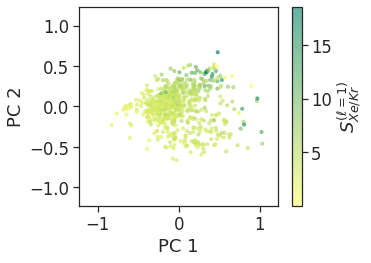

In [18]:
cmap_name = cm.summer_r # sequential colormap (reversed)

###
#  low dimensional (PCA) visualization of the entire dataset
###
fig = plt.figure()
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name, s=10, alpha=0.6)

###
#  axis commands
###
ax_lim = max([np.max(X_2D), abs(np.min(X_2D))]) + 0.2
plt.xlim([-ax_lim, ax_lim])
plt.ylim([-ax_lim, ax_lim])

plt.xticks()
plt.yticks()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")

plt.gca().set_aspect('equal', 'box')

plt.tight_layout()
if save_plots:
    plt.savefig("./figs/PCA_feature_space_colored_by_GCMC_Selectivity.pdf", format="pdf")
plt.show()

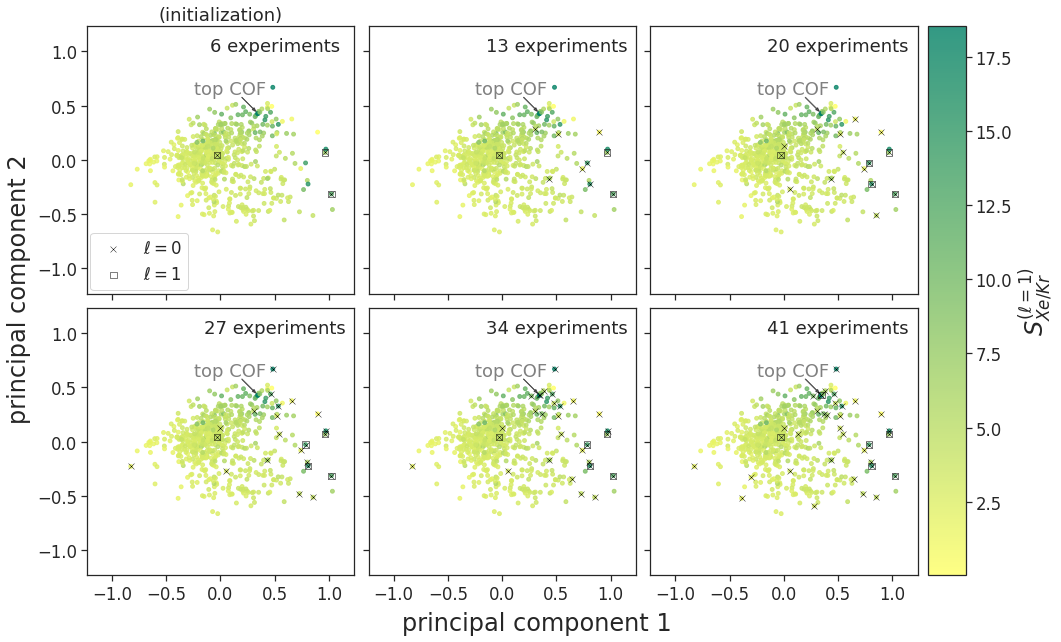

In [19]:
panel_step = np.ceil((mfbo_res['BO_iter_top_cof_acquired'][0] - 2*nb_COFs_initialization) / 5)

nb_acquired = [2*nb_COFs_initialization + i*int(panel_step) for i in range(6)]

nb_acquired[len(nb_acquired) - 1] = mfbo_res['BO_iter_top_cof_acquired'][0] + 1 # have to adjust the indexing

# set up figure and image grid
fig = plt.figure(figsize=[3*6.4 + 0.5, 4.8*2 + 0.5])

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2, 3),
                 axes_pad=0.2,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# add data to image grid
for (i, nb), ax in zip(enumerate(nb_acquired), grid):
    acq = mfbo_res['acquired_set'][0][:nb]
    lf_acq = acq[acq[:, 0] == 0, :] # low-fidelity
    hf_acq = acq[acq[:, 0] == 1, :] # high-fidelity
    assert len(lf_acq) + len(hf_acq) == len(acq)
    ###
    #  plot PCA for all COFs
    ###
    pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                             facecolor='none', s=15, alpha=0.8) 
    
    ### 
    # plot center of feature space and transformed point
    ###
#     if i == 0:
#         ax.scatter(X_center[:, 0], X_center[:, 1], color="b", marker="*", s=30)

    ###
    #  indicate top COF
    #  arrow is drawn from (x, y) to (x+dx, y+dy)
    ###
    top_cof_id = np.argmax(y[1])
    eps = 0.15
    ax.arrow(X_2D[top_cof_id, 0]-eps, X_2D[top_cof_id, 1]+eps, eps*0.7, -eps*0.7,
             head_width=0.025, color='k', alpha=0.6)
    ax.text(X_2D[top_cof_id, 0]-3.95*eps, X_2D[top_cof_id, 1]+1.2*eps, 'top COF', color="grey")

    ###
    #  indicate acquired points at the given iteration
    ###
    # low-fidelity
    ax.scatter(X_2D[lf_acq[:nb, 1], 0], X_2D[lf_acq[:nb, 1], 1], 
                  label="$\ell=0$",
                  color='k', marker='x', s=35, lw=0.45, zorder=2) 
    # high-fidelity
    ax.scatter(X_2D[hf_acq[:nb, 1], 0], X_2D[hf_acq[:nb, 1], 1], 
               label="$\ell=1$",
               fc='none', ec='k', marker='s', s=40, lw=0.5, zorder=10)
    

    
    # subplot titles --- use ax.text 
    if i == 0:
        ax.set_title('(initialization)')
    ax.text(0.5, 1.0, '{} experiments'.format(nb_acquired[i]), ha='center')
        
    ax.tick_params(axis='x')
    ax.set_aspect('equal', 'box')

###
#  colorbar
###
cb = ax.cax.colorbar(pca_base)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$", fontsize=24)

###
#  axis commands
###
grid[0].legend(loc=(0.013, 0.013))
fig.text(0.155, 0.52, 'principal component 2', ha='center', va='center', rotation='vertical', fontsize=24)
fig.text(0.52, 0.05, 'principal component 1', ha='center', fontsize=24)

grid[0].set_xlim([-ax_lim, ax_lim])
grid[0].set_ylim([-ax_lim, ax_lim])


if save_plots:
    plt.savefig("./figs/MFBO_PCA_dynamics.pdf", bbox_inches="tight", format="pdf")
plt.show()

# Radar Plot of Feature Vector

custom scale on each axis adapted from code [here](https://datascience.stackexchange.com/questions/6084/how-do-i-create-a-complex-radar-chart)

In [20]:
###
#  load data
###
cof_file = h5py.File("top_COF_feature_vector.jld2", "r")
values = np.array(cof_file['features']).tolist()
print("Top COF ID = ", top_cof_id)
print("Top COF feature vector:\n", values)

# descriptors
property_type = ['geometric', 'chemical']
descriptors = []

for prop in property_type:
    filename = "descriptors/{}_properties.csv".format(prop)
    df = pd.read_csv(filename)
    for descriptor in df.columns:
        if descriptor != "crystal_name": 
            descriptors.append(descriptor)
            
###
#  fix labels for plotting
###
pretty_des_names = dict({'pore_diameter_Å': 'pore\ndiameter [Å]', 
                         'void_fraction': 'void fraction',
                         'surface_area_m²g⁻¹': 'surface area [m² g⁻¹]',
                         'crystal_density': 'crystal density [kg m⁻³]'
                        })

for n, des in enumerate(descriptors):
    if des in pretty_des_names.keys():
        descriptors[n] = pretty_des_names[des] + ''
    else:
        descriptors[n] = descriptors[n] + ""
        
print("feature labels: \n", descriptors)

Top COF ID =  375
Top COF feature vector:
 [5.74091, 0.33218, 4502.94, 1071.1983709342826, 0.0, 0.0, 0.5369127516778524, 0.348993288590604, 0.0, 0.10738255033557047, 0.0, 0.0, 0.0, 0.006711409395973154]
feature labels: 
 ['pore\ndiameter [Å]', 'void fraction', 'surface area [m² g⁻¹]', 'crystal density [kg m⁻³]', 'B', 'O', 'C', 'H', 'Si', 'N', 'S', 'P', 'halogens', 'metals']


In [21]:


def _scale_data(data, ranges):
    """scales data[1:] to ranges[0]"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    sdata = [data[0]] 
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges, n_ordinate_levels=6):
        # divide circle into equal parts
        angles = np.arange(0, 360, 360./len(variables))
        
        # make a list of the axes (one per dscriptor variable)
        # [0.1, 0.1, 0.9, 0.9]
        axes = [fig.add_axes([0.0, 0.0, 1.0, 1.0], polar=True, label="axes{}".format(i)) 
                for i in range(len(variables))]
        
        # put variable name at the correct angle
        # adjust rotation of text for readability
        l, text = axes[0].set_thetagrids(angles, labels=variables, fontsize=26)
        [txt.set_rotation(angle-90) for txt, angle in zip(text, angles)] 
        
        # overlay each axis
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off", lw=1)
            ax.xaxis.set_visible(False)
            
        # specify grid labels
        for i, ax in enumerate(axes): 
            # ax.set_axisbelow(False)
            ax.yaxis.set_zorder(0)

            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            gridlabel = [] #["{0:.2f}".format(round(x, 2)) for x in grid]
            for j, x in enumerate(grid):
                if j == 0 or j == len(grid)-1:
                    gridlabel.append("{0:.1f}".format(round(x, 2)))
                else:
                    gridlabel.append('')
            
            gridlabel[0] = "" # clean up origin

            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[i], fontsize=20, color='grey') 
            
            ###
            #  Go through labels and adjust alignment based on where
            #  it is in the circle.
            ###
            for label in labels:
                if angles[i] == 0:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('bottom')
                elif 0 < angles[i] < 55:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('top')
                elif 55 <= angles[i] < 90:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('top')
                elif 90 <= angles[i] < 180:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('top')
                elif angles[i] == 180.0:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 180 < angles[i] < 225:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 225 <=  angles[i] < 270:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 270 <=  angles[i] < 300:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('bottom')
                elif 300 <= angles[i]:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('baseline')
            
            # if i == 0:
            #     ax.set_zorder(10)
            # else:
            #     ax.set_zorder(10)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        
        ###    
        #  variables for plotting
        ###
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

        
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        # put this one on top so gridlines don't overlap data
        self.ax.set_zorder(100)
        
        self.ax.spines["polar"].set_visible(True)

        ###
        #  Go through labels and adjust alignment based on where
        #  it is in the circle.
        ###
        for label, angle in zip(self.ax.get_xticklabels(), self.angle):
            ang = np.rad2deg(angle)
            if ang == 0:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center_baseline')
            elif 0 < ang < 90:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center_baseline')
            elif 55 <= ang < 90:
                label.set_horizontalalignment('right')
                label.set_verticalalignment('bottom')
            elif 90 <= ang < 180:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif ang == 180.0:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center')
            elif 180 < ang < 225:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif 225 <=  ang < 270:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif 270 <=  ang:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center')
        ###        
        #  make the pannel transparent so you can see the 
        #  plot labels below it
        ###
        self.ax.patch.set_alpha(0.0)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


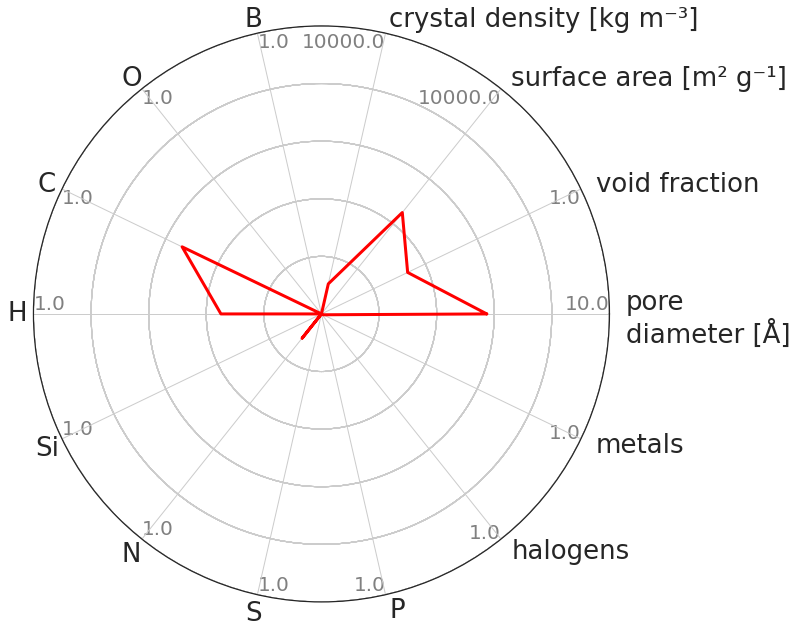

In [22]:
###
#  data
###
variables = tuple(descriptors)
data = tuple(values)
# ymax will be 10**(base) 
ranges = []
for val in values:
    if 0 <= val <= 1:
        base = 0
    else:
        base = int(np.ceil(np.log10(val)))
    ranges.append((0, 10**base))
    
###
#  plotting
###
fig1 = plt.figure(figsize=(8, 8)) 
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data, color='red', alpha=1.0, lw=3) 
# radar.fill(data, color='red', alpha=0.25)

if save_plots:
    plt.savefig("./figs/top_COF_raw_feature_vector_radar.pdf", bbox_inches="tight", format='pdf')

plt.show()


###
#  TODO: HOW DO I GET THE THETAGRID LINES TO STOP CUTTING THROUGH THE LABELS
# 
#  TODO: MAYBE I NEED TO JUST ERASE THE LABELS AND REPRINT THEM IN THE END USING
#        PLT.TEXT(STR, fontsize=20, color='grey') 
#        TO PUT THE RADIAL LABELS ON THE PLOT? I SHOULD BE ABLE 
#        TO JUST USE THE SIZE AND COLORS OF THE RADAR PLOT
# 
#  TODO: RADAR PLOT - <br></br>
#        1. plot the top 5 COFs in green, with transparancy fill
#        2. plot the bottom 5 COFs in red, with transarancy fill
# 
#        Are there any differences in the shapes?
#        I should just be able to sort the selectivies from the acquired set?
###

## radar plot multiple cofs

In [30]:
high_performing_cofs = np.argsort(y[1])[-5:]
high_performing_cofs

array([521, 319, 237, 376, 375])

In [35]:
poor_performning_cofs = np.argsort(y[1])[:5]
poor_performning_cofs

array([526,  98, 262, 336, 338])

In [54]:
targets_and_features = h5py.File("targets_and_raw_features.jld2", "r")
targets_and_features.keys()

<KeysViewHDF5 ['X', 'gcmc_elapsed_time', 'gcmc_y', 'henry_total_elapsed_time', 'henry_y']>

In [60]:

cof_feature_values = np.array(targets_and_features['X'])
cof_feature_values[1]

array([0.3102 , 0.64806, 0.71368, 0.36936, 0.56072, 0.7131 , 0.73572,
       0.88136, 0.88836, 0.63932, 0.23682, 0.3622 , 0.45334, 0.55394,
       0.37584, 0.68606, 0.64274, 0.51134, 0.41056, 0.55132, 0.56224,
       0.60158, 0.50276, 0.7154 , 0.65894, 0.51004, 0.57796, 0.62636,
       0.80306, 0.77964, 0.54566, 0.4587 , 0.61696, 0.6175 , 0.6157 ,
       0.57892, 0.69426, 0.6757 , 0.7216 , 0.60248, 0.59904, 0.42052,
       0.55472, 0.55392, 0.548  , 0.25916, 0.6447 , 0.69022, 0.71026,
       0.82292, 0.30938, 0.61378, 0.54778, 0.59178, 0.60606, 0.6265 ,
       0.58366, 0.57388, 0.5282 , 0.4968 , 0.4922 , 0.48382, 0.53844,
       0.67734, 0.67096, 0.55632, 0.5519 , 0.63944, 0.71322, 0.6117 ,
       0.7759 , 0.34894, 0.5252 , 0.44638, 0.64826, 0.68376, 0.74926,
       0.63308, 0.35514, 0.3954 , 0.3228 , 0.40046, 0.60106, 0.4733 ,
       0.54652, 0.66982, 0.74042, 0.71134, 0.71906, 0.69958, 0.63422,
       0.68758, 0.66046, 0.71284, 0.67426, 0.76322, 0.68926, 0.6909 ,
       0.16356, 0.65

In [ ]:
    
###
#  plotting
###
fig1 = plt.figure(figsize=(8, 8)) 


radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data, color='red', alpha=1.0, lw=3) 
# radar.fill(data, color='red', alpha=0.25)

# if save_plots:
#     plt.savefig("./figs/top_COF_raw_feature_vector_radar.pdf", bbox_inches="tight", format='pdf')

plt.show()